In [1]:
#! pip install tensorflow==2.6.2

In [2]:
#! pip install numpy==1.20.3

In [3]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.11.0', '1.22.4')

In [4]:
from google.colab.patches import cv2_imshow

In [5]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "/content/drive/MyDrive/CV_Signature_Dataset"

In [6]:
def read_image_train(index):
    path = os.path.join(ROOT, index.split('_')[0],'Train', index)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [7]:
def read_image_test(index):
    path = os.path.join(ROOT, index.split('_')[0],'Test', index)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [8]:
def split_dataset(directory, split=1):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    # Creating Test-list
    for folder in folders:
        train_list[folder] = len(os.listdir(os.path.join(directory, folder,'Train')))
        test_list[folder] =  len(os.listdir(os.path.join(directory, folder,'Test')))
    
    return train_list, test_list

In [9]:
train_list, test_list = split_dataset(ROOT)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

Length of training list: 5
Length of testing list : 5


In [10]:
train_list

{'personA': 41, 'personB': 41, 'personD': 41, 'personC': 41, 'personE': 41}

In [81]:
def create_triplets_train(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        real = []
        forged = []
        path = os.path.join(directory, folder,'Train',f'{folder}_SigVerificationTrainLabels.csv')
        data = np.recfromcsv(path,encoding=None)
      
        for row in data:
          if row[1] == 'real':
            real.append(row[0])
          else:
            forged.append(row[0])
        
        num_files = len(real)
        for i in range(num_files-1):
            for j in range(i+1,num_files):
                 anchor = (f"{real[i]}")
                 positive = (f"{real[j]}")
                 neg_folder = folder
                 neg_file = random.choice(forged)
                 negative = (f"{neg_file}")

                 triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [82]:
def create_triplets_test(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        real = []
        forged = []
        path = os.path.join(directory, folder,'Test',f'{folder}_SigVerificationTestLabels.csv')
        data = np.recfromcsv(path,encoding=None)
        
        for row in data:
          if row[1] == 'real':
            real.append(row[0])
          else:
            forged.append(row[0])
        

        num_files = len(real)
        for i in range(num_files-1):
            for j in range(i+1,num_files):
                 anchor = (f"{real[i]}")
                 positive = (f"{real[j]}")
                 neg_file = random.choice(forged)
                 negative = (f"{neg_file}")
              
                

                 triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [83]:
train_triplet = create_triplets_train(ROOT, train_list)
test_triplet  = create_triplets_test(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 950
Number of testing triplets : 30

Examples of triplets:
('personD_2.png', 'personD_42.png', 'personD_3.png')
('personE_47.png', 'personE_46.png', 'personE_44.png')
('personB_39.png', 'personB_19.png', 'personB_11.png')
('personA_43.png', 'personA_26.png', 'personA_16.png')
('personE_42.png', 'personE_29.png', 'personE_13.png')


In [34]:
train_triplet[0][0].split('_')[0]

'personE'

In [84]:
def get_batch_train(triplet_list, batch_size=256, preprocess=True,target_size=(128, 128)):
    batch_steps = len(triplet_list)//batch_size
        
    #while True:
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
    
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            a_img = read_image_train(a)
            p_img = read_image_train(p)
            n_img = read_image_train(n)

            anchor_img = cv2.resize(a_img, target_size)
            positive_img = cv2.resize(p_img, target_size)
            negative_img = cv2.resize(n_img, target_size)

            anchor.append(anchor_img)
            positive.append(positive_img)
            negative.append(negative_img)

            j+=1


        
    
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)


        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

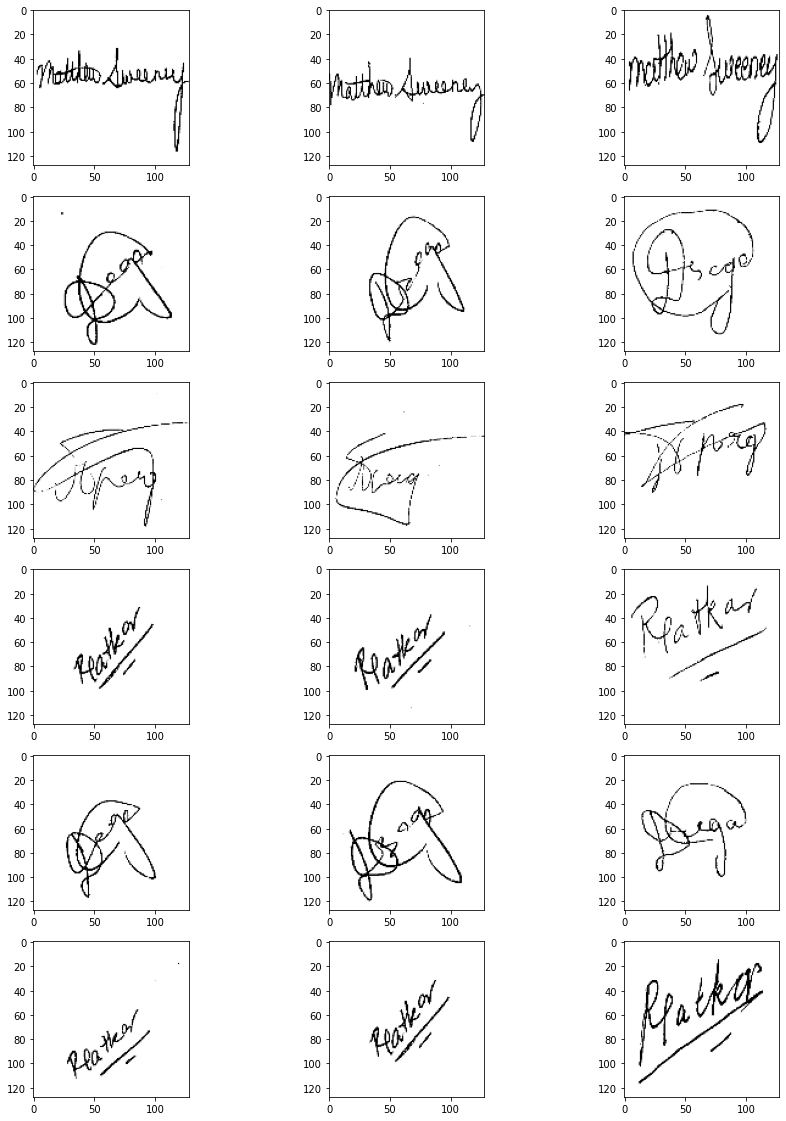

In [85]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch_train(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [86]:
def get_batch_test(triplet_list,batch_size=256,preprocess=True,target_size=(128, 128)):
    batch_steps = len(triplet_list)//batch_size

    #while True:
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
    
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            a_img = read_image_test(a)
            p_img = read_image_test(p)
            n_img = read_image_test(n)

            anchor_img = cv2.resize(a_img, target_size)
            positive_img = cv2.resize(p_img, target_size)
            negative_img = cv2.resize(n_img, target_size)

            anchor.append(anchor_img)
            positive.append(positive_img)
            negative.append(negative_img)

            j+=1


        
    
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)

        if preprocess:
              anchor = preprocess_input(anchor)
              positive = preprocess_input(positive)
              negative = preprocess_input(negative)

        yield ([anchor, positive, negative])

In [87]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [88]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [89]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                  

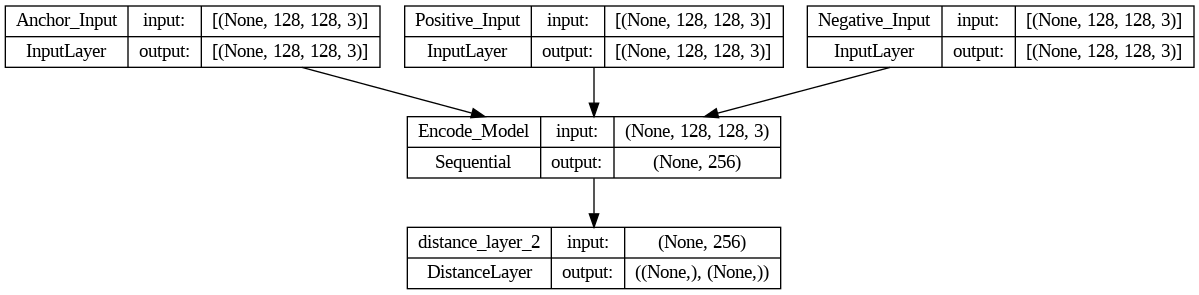

In [90]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [91]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [92]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [93]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []
    
    for data in get_batch_test(test_triplet, batch_size=batch_size):
        print(len(data[0]))
        if len(data[0]) == 0:
            break
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
        
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [94]:
save_all = False
epochs = 20
batch_size = 10

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch_train(train_triplet, batch_size=batch_size):
        #print(len(data[0]))
        if len(data[0]) == 0:
            break
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy 
# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 34 sec)
Loss on train    = 0.21033
10
1/1 [==============================] - 2s 2s/step
10
1/1 [==============================] - 0s 44ms/step
10
1/1 [==============================] - 0s 49ms/step
0
Accuracy on test = 0.93333

EPOCH: 2 	 (Epoch done in 21 sec)
Loss on train    = 0.00941
10
1/1 [==============================] - 0s 46ms/step
10
1/1 [==============================] - 0s 43ms/step
10
1/1 [==============================] - 0s 43ms/step
0
Accuracy on test = 0.90000

EPOCH: 3 	 (Epoch done in 22 sec)
Loss on train    = 0.00607
10
1/1 [==============================] - 0s 46ms/step
10
1/1 [==============================] - 0s 47ms/step
10
1/1 [==============================] - 0s 56ms/step
0
Accuracy on test = 0.90000

EPOCH: 4 	 (Epoch done in 22 sec)
Loss on train    = 0.00355
10
1/1 [==============================] - 0s 60ms/step
10
1/1 [==============================] - 0s 62ms/step
10
1/1 [==============================] - 0s 59ms/step
0
Accur

In [95]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_24 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 lambda_4 (Lambda)           (None, 256)               0         
                                                      

In [96]:
def classify_images(signature_list1, signature_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(signature_list1)
    tensor2 = encoder.predict(signature_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

1/1 [==============================] - 0s 31ms/step

Accuracy of model: 0.85



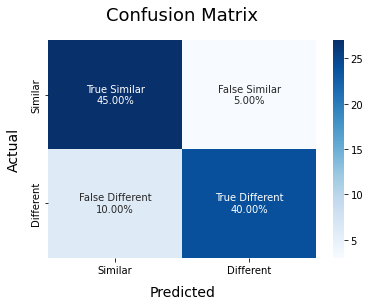

In [97]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    

pos_list = np.array([])
neg_list = np.array([])

for data in get_batch_test(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)